In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from src.autoencoder import AutoEncoder
from src.utils import *
from src.rtd import RTDLoss, Rips, RTD_differentiable
from src.top_ae import TopologicallyRegularizedAutoencoder # Bastian Rieck

import umap

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from collections import defaultdict

from tqdm.notebook import tqdm

In [30]:
config = {
    "dataset_name":"COIL-20",
    "version":"cnn_max_scaled_e60_b80",
    "model_name":"default",
    "max_epochs":60,
    "gpus":[1],
    "n_neighbors":[5, 20, 100, 400],
    "rtd_every_n_batches":1,
    "rtd_start_epoch":1,
    "rtd_l":1.0, # rtd loss 
    "n_runs":1, # number of runs for each model
    "card":50, # number of points on the persistence diagram
    "n_threads":50, # number of threads for parallel ripser computation of pers homology
    "latent_dim":2, # latent dimension (2 for vizualization purposes)
    "input_dim":(128, 128),
    "n_hidden_layers":2,
    "hidden_dim":32,
    "batch_size":80,
    "width":128,
    "heigth":128,
    "engine":"giotto",
    "is_sym":True
}

In [31]:
def get_model(input_dim, latent_dim=2, n_hidden_layers=2, hidden_dim=32, m_type='encoder'):
    layers = list(
        chain.from_iterable(
            [
                (nn.Linear(hidden_dim, hidden_dim), nn.ReLU()) for _ in range(n_hidden_layers)
            ]
        )
    )
    if m_type == 'encoder':
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()] + layers + [nn.Linear(hidden_dim, latent_dim)]
    elif m_type == 'decoder':
        layers = [nn.Linear(latent_dim, hidden_dim), nn.ReLU()] + layers + [nn.Linear(hidden_dim, input_dim)]
    return nn.Sequential(*layers)

def get_list_of_models(**config):
    # define a list of models
    encoder = get_cnn_model(
        m_type='encoder',
        **config
    )
    decoder = get_cnn_model(
        m_type='decoder',
        **config
    )
    models = {
        'Basic AutoEncoder':AutoEncoder(
           encoder = encoder,
            decoder = decoder,
            MSELoss = nn.MSELoss(),
            **config
        ),
        'Topological AutoEncoder':TopologicallyRegularizedAutoencoder(
            encoder = encoder,
            decoder = decoder,
            MSELoss = nn.MSELoss(),
            **config
        ),
#         "UMAP":umap.UMAP(n_components=config['latent_dim']),
#         "PCA":PCA(n_components=config['latent_dim']),
#         "TSNE": TSNE(n_components=config['latent_dim']),
        'RTD AutoEncoder H1':AutoEncoder(
            encoder = encoder,
            decoder = decoder,
            RTDLoss = RTDLoss(dim=1, **config), # only H1
            MSELoss = nn.MSELoss(),
            **config
        ),
        'RTD AutoEncoder H2':AutoEncoder(
            encoder = encoder,
            decoder = decoder,
            RTDLoss = RTDLoss(dim=2, **config), # only H2
            MSELoss = nn.MSELoss(),
            **config
        )
    }
    return models

In [32]:
def collate_with_matrix(samples):
    indicies, data, labels = zip(*samples)
    data, labels = torch.tensor(np.asarray(data)), torch.tensor(np.asarray(labels, dtype=np.uint8))
    if len(data.shape) > 2:
        dist_data = torch.flatten(data, start_dim=1)
    else:
        dist_data = data
    x_dist = torch.cdist(dist_data, dist_data, p=2) / np.sqrt(dist_data.shape[1])
#     x_dist = (x_dist + x_dist.T) / 2.0 # make symmetrical (cdist is prone to computational errors)
    return data, x_dist, labels

In [33]:
dataset_name = config['dataset_name']
train_data = np.load(f'data/{dataset_name}/prepared/data.npy').astype(np.float32)

try:
    test_data = np.load(f'data/{dataset_name}/prepared/test_data.npy').astype(np.float32)
except FileNotFoundError:
    ids = np.random.choice(np.arange(len(train_data)), size=int(0.2*len(train_data)), replace=False)
    test_data = train_data[ids]

try:
    train_labels = np.load(f'data/{dataset_name}/prepared/labels.npy')
except FileNotFoundError:
    train_labels = None

try:
    test_labels = np.load(f'data/{dataset_name}/prepared/test_labels.npy')
except FileNotFoundError:
    test_labels = None

In [34]:
# scaler = FurthestScaler()
scaler = None
train = FromNumpyDataset(np.expand_dims(train_data, 1)/255.0, train_labels, scaler = scaler, flatten=False)
test = FromNumpyDataset(np.expand_dims(test_data, 1)/255.0, test_labels, scaler = train.scaler, flatten=False)

train_loader = DataLoader(
    train, 
    batch_size=config["batch_size"], 
    num_workers=2, 
    collate_fn=collate_with_matrix, 
    shuffle=True
)
val_loader = DataLoader(
    test,
    batch_size=config["batch_size"],
    num_workers=2,
    collate_fn=collate_with_matrix,
)

In [35]:
def train_autoencoder(model, train_loader, val_loader=None, model_name='default', 
                      dataset_name='MNIST', gpus=[3], max_epochs=100, run=0, version=""):
    version = f"{dataset_name}_{model_name}_{version}_{run}"
    logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), name='lightning_logs', version=version)
    trainer = pl.Trainer(
        logger=logger, 
        gpus=gpus, 
        max_epochs=max_epochs, 
        log_every_n_steps=50, 
        num_sanity_val_steps=0
    )
    trainer.fit(model, train_loader, val_loader)
    return model

# def validate_knn(train, test, n_neighbors, model_name, accuracies=defaultdict(list)):
#     train_data, train_labels = train
#     test_data, test_labels = test
#     for k in n_neighbors:
#         classifier = KNeighborsClassifier(n_neighbors=k)
#         classifier.fit(train_data, train_labels)
#         pred_labels = classifier.predict(test_data)
#         accuracies[model_name + f"_k{k}"].append(accuracy_score(test_labels, pred_labels))
#     return accuracies

def dump_figures(figures, dataset_name, version):
    for model_name in figures:
        figures[model_name].savefig(f'results/{dataset_name}/{dataset_name}_{model_name}_{version}.png')

def train_models(train_loader, val_loader, dataset_name="", max_epochs=1, gpus=[], n_neighbors=[1], n_runs=1, version='', **kwargs):
    training_time = defaultdict(list)
    accuracies = defaultdict(list)
    figures = {} # figures for each model run
    trained_models = []
    for run in range(n_runs):
        models = get_list_of_models(**kwargs)
        for model_name in tqdm(models, desc=f"Training models, run: {run+1} out of {n_runs}"):
            start_time = time.time()
            if 'AutoEncoder' in model_name: # train an autoencoder
                    start_time = time.time()
                    models[model_name] = train_autoencoder(
                        models[model_name], 
                        train_loader, 
                        val_loader, 
                        model_name, 
                        dataset_name,
                        gpus,
                        max_epochs,
                        run,
                        version
                    )
                    val_latent, val_labels = get_latent_representations(models[model_name], val_loader)
                    train_latent, train_labels = get_latent_representations(models[model_name], train_loader)
            else: # umap / pca / t-sne (sklearn interface)
                train_latent = models[model_name].fit_transform(train_loader.dataset.data)
                try:
                    val_latent =  models[model_name].transform(test_loader.dataset.data)
                except AttributeError as e:
                    print(model_name)
                    print(e)
                    val_latent = train_latent
            # measure training time
            end_time = time.time()
            training_time[model_name].append(end_time-start_time)
            # Plot latent distributions
            fig, _ = plot_latent(train_latent, train_labels, model_name, dataset_name)
            figures[model_name + f"_{run}"] = fig
            # Calculate knn accuracies and dump them
#             accuracies = validate_knn((train_latent, train_labels), (val_latent, val_labels), n_neighbors, model_name, accuracies)
#             json.dump(accuracies, open(f'results/{dataset_name}/{dataset_name}_{version}_acc.json', 'w'))
            # save trained models
        trained_models.append(models)
    # save figures
    dump_figures(figures, dataset_name, version)
    # save training times
    json.dump(training_time, open(f'results/{dataset_name}/{dataset_name}_{version}_time.json', 'w'))
    # save accuracies
#     json.dump(accuracies, open(f'results/{dataset_name}/{dataset_name}_{version}_acc.json', 'w'))
    return accuracies, figures, training_time, trained_models

In [ ]:
acc, figures, training_time, trained_models = train_models(train_loader, val_loader, **config)

Using python to compute signatures


Training models, run: 1 out of 1:   0%|          | 0/4 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 75.2 K
1 | decoder | Sequential | 107 K 
2 | MSELoss | MSELoss    | 0     
---------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.733     Total estimated model params size (MB)
/workspace/topological_autoencoders/.env/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:408: UserWarning: The number of training samples (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | encoder  | Sequential                   | 75.2 K
1 | decoder  | Sequential                   | 107 K 
2 | MSELoss  | MSELoss                      | 0     
3 | topo_sig | TopologicalSignatureDistance | 0     
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.733     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 75.2 K
1 | decoder | Sequential | 107 K 
2 | RTDLoss | RTDLoss    | 0     
3 | MSELoss | MSELoss    | 0     
---------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.733     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 75.2 K
1 | decoder | Sequential | 107 K 
2 | RTDLoss | RTDLoss    | 0     
3 | MSELoss | MSELoss    | 0     
---------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.733     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Visualization

In [16]:
models = trained_models[0]

In [12]:
from matplotlib.cm import hsv, twilight_shifted
%matplotlib notebook

In [25]:
model_name = 'RTD AutoEncoder H2'
# latent = models[model_name].embedding_
latent, labels = get_latent_representations(models[model_name], train_loader)

In [26]:
labels = train_labels

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Model: RTD AutoEncoder H2, dataset:COIL-20'}>)

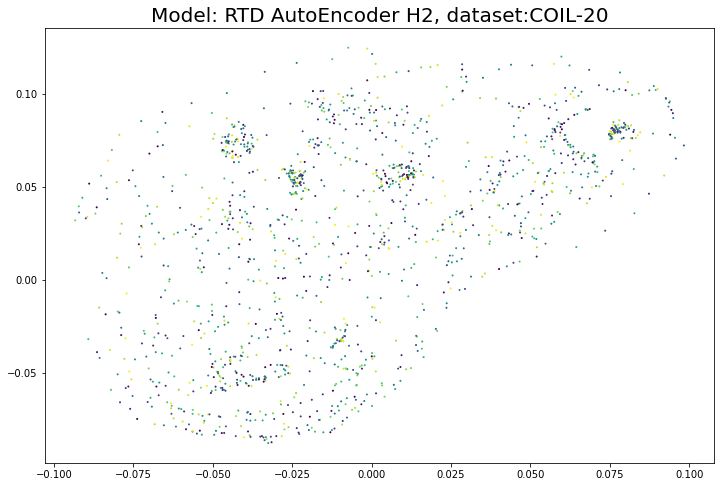

In [27]:
plot_latent(latent, labels, model_name = model_name, dataset_name=config['dataset_name'])

In [26]:
orientation_angles = np.load('data/dSprites/prepared/orientation.npy') # from 0 to 2 (in pi's)
place_angles = np.load('data/dSprites/prepared/coordinate.npy')

<IPython.core.display.Javascript object>


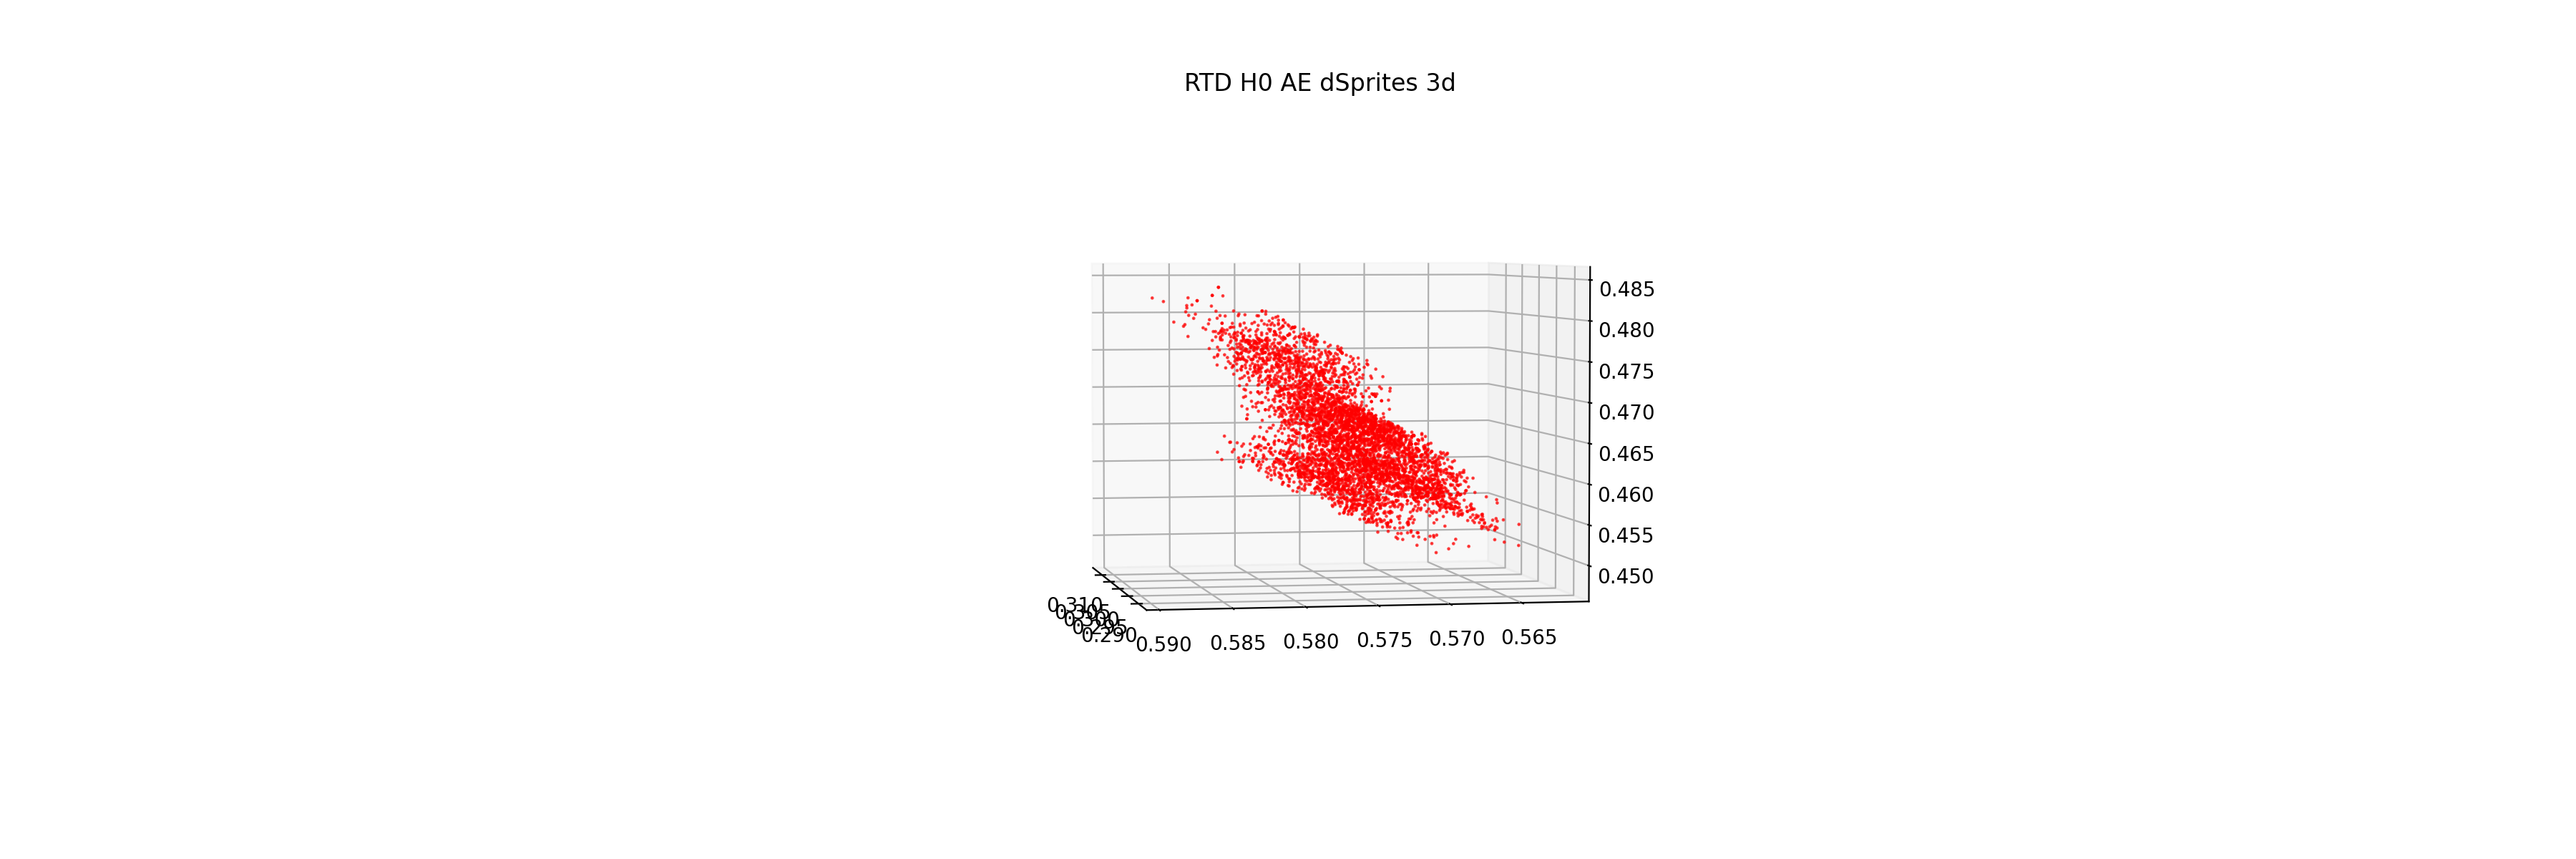

In [27]:
def plot_3d(latent, labels, alpha=0.7, s=0.5, title=""):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], alpha=alpha, c=labels, s=s, cmap=hsv)
    ax.set_title(title)
    return fig, ax

fig, ax = plot_3d(latent, labels, title="RTD H1 AE dSprites 3d")

In [ ]:
print(rc['pairs'])

In [58]:
def plot_images(imgs, latent, zoom=1.0, n=10):
    """
    Plot data with images
    """
    assert imgs.shape[0] == latent.shape[0], "Latent and images doesn't match"
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ids = np.random.choice(np.arange(len(latent)), size=n)
    ax.scatter(latent[:, 0], latent[:, 1], alpha=0.7, s=0.5)
    for idx in tqdm(ids, desc="Adding images to plot"):
        im = OffsetImage(imgs[idx], zoom=zoom)
        xy = latent[idx]
        ab = AnnotationBbox(im, xy, xycoords='data', pad=0.)
        ax.add_artist(ab)
    return fig, ax

Adding images to plot:   0%|          | 0/1000 [00:00<?, ?it/s]

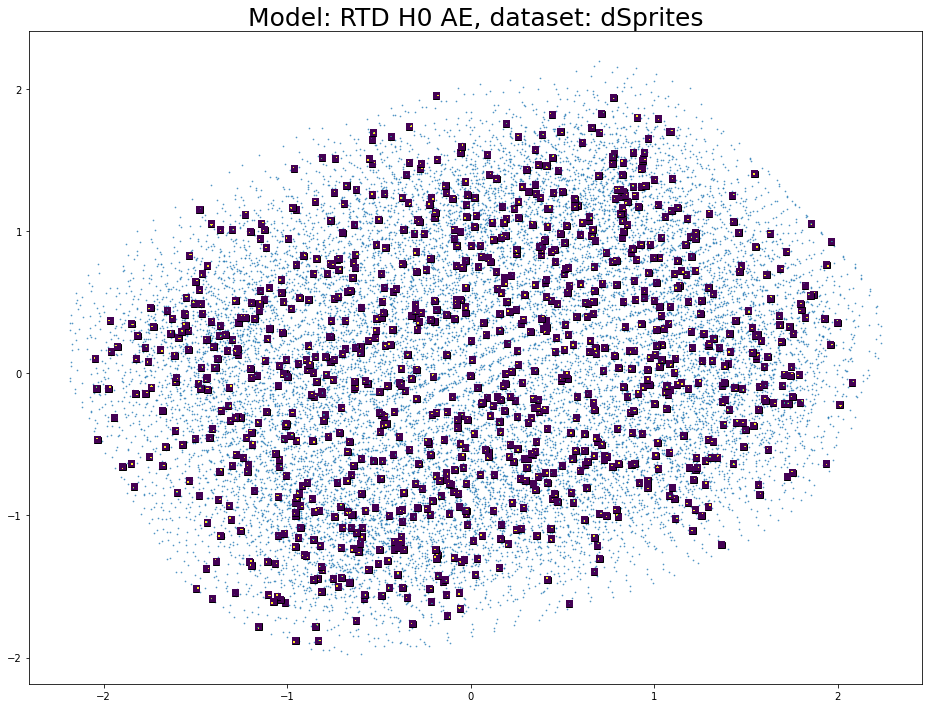

In [61]:
fig, ax = plot_images(train_data, latent, zoom=0.1, n=1000)
ax.set_title("Model: RTD H0 AE, dataset: dSprites", fontsize=25)
plt.show()

In [62]:
fig.savefig('results/dSprites/dSprites_RTD AutoEncoder H0_0_param_scaled_no_orientation_images.png', dpi=2000)

In [63]:
model = umap.UMAP(n_components=2)

In [ ]:
umap_latent = model.fit_transform(train_data.reshape(train_data.shape[0], -1))

In [ ]:
umap_latent

### Scaling constant

In [27]:
trained_models[0]['RTD AutoEncoder H0'].norm_constant

Parameter containing:
tensor([1.0399], requires_grad=True)



#### Scaling parameter:

| Dataset   | Scaled | Value  |
| --------- | ------ | ------ |
| Infty     | True   | 1.3401 |
| Infty     | False  | 1.1144 |
| Spheres   | False  | 3.8995 |
| Spheres   | True   | 1.3766 |